In [1]:
import glob
import niwaves
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce

In [2]:
subjects = ['sub-MSC01',
            'sub-MSC02',
            'sub-MSC03',
            'sub-MSC04',
            'sub-MSC05',
            'sub-MSC06',
            'sub-MSC07',
            'sub-MSC08',
            'sub-MSC09',
            'sub-MSC10']
sessions = ['ses-func01',
            'ses-func02',
            'ses-func03',
            'ses-func04',
            'ses-func05']
tasks = ['task-rest',
         'task-motor',
         'task-memory*',
         'task-glasslexical']
runs = ['run-01']
ts = {
      task: {
       sub: {
        ses: {
         run: {'roi': glob.glob('data/MSC/ts/{}_{}_{}_run-*_schaefer400_ts.1D'.format(sub, ses, task)),
          'motion': glob.glob('data/MSC/motion/{}_{}_{}_run-*_relRMS.1D'.format(sub, ses, task))
         } for run in runs
        } for ses in sessions
       } for sub in subjects
      } for task in tasks
     }

In [3]:
community = pd.read_table('data/network/schaefer400x7CommunityAffiliation.1D', header=None)

In [4]:
# Rest: session level.
ts_rest = {}
ts_motion = {}
lags_rest = {}
peaks_rest = {}
tmask_rest = {}
for sub in subjects:
    lags_rest[sub] = {}
    peaks_rest[sub] = {}
    tmask_rest[sub] = {}
    for ses in sessions:
        ts_rest[ses] = pd.read_csv(ts['task-rest'][sub][ses]['run-01']['roi'][0],
                                   sep=' ', header=None)
        ts_motion[ses] = pd.read_csv(ts['task-rest'][sub][ses]['run-01']['motion'][0],
                                     sep=' ', header=None)
        tmask_rest[sub][ses] = ts_motion[ses] < 0.2
        lags_rest[sub][ses], peaks_rest[sub][ses] = niwaves.lag_analysis(timeseries1=ts_rest[ses].values,
                                                                         tmask=tmask_rest[sub][ses].values,
                                                                         sample_time=2.2,
                                                                         min_block=10,
                                                                         lagmax=3)

/home/vagrant/miniconda3/envs/py3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


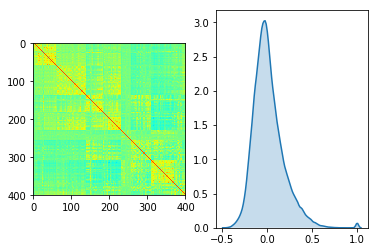

In [5]:
# Aggregate all matrices
group = np.zeros([len(subjects)*len(sessions), len(community), len(community)])
for i, sub in enumerate(subjects):
    for j, ses in enumerate(sessions):
        group[i*len(sessions)+j,:,:] = peaks_rest[sub][ses]

# Compute the average matrix across the sample
groupmean = np.nanmean(group, axis=0).squeeze()
niwaves.lag_sort(groupmean, community=community)
groupmean = np.abs(groupmean)
groupmean[np.diag_indices_from(groupmean)] = 0

0 . . . 1 . . . 2 . . . 3 . . . 4 . . . 5 . . . 6 . . . 7 . . . 8 . . . 9 . . . 10 . . . 11 . . . 12 . . . 13 . . . 14 . . . 15 . . . 16 . . . 17 . . . 18 . . . 19 . . . 20 . . . 21 . . . 22 . . . 23 . . . 24 . . . 25 . . . 26 . . . 27 . . . 28 . . . 29 . . . 30 . . . 31 . . . 32 . . . 33 . . . 34 . . . 35 . . . 36 . . . 37 . . . 38 . . . 39 . . . 40 . . . 41 . . . 42 . . . 43 . . . 44 . . . 45 . . . 46 . . . 47 . . . 48 . . . 49 . . . 50 . . . 51 . . . 52 . . . 53 . . . 54 . . . 55 . . . 56 . . . 57 . . . 58 . . . 59 . . . 60 . . . 61 . . . 62 . . . 63 . . . 64 . . . 65 . . . 66 . . . 67 . . . 68 . . . 69 . . . 70 . . . 71 . . . 72 . . . 73 . . . 74 . . . 75 . . . 76 . . . 77 . . . 78 . . . 79 . . . 80 . . . 81 . . . 82 . . . 83 . . . 84 . . . 85 . . . 86 . . . 87 . . . 88 . . . 89 . . . 90 . . . 91 . . . 92 . . . 93 . . . 94 . . . 95 . . . 96 . . . 97 . . . 98 . . . 99 . . . 

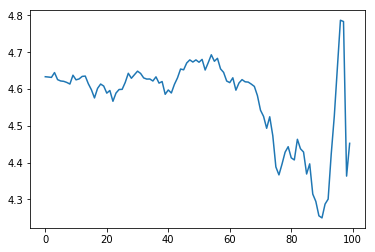

In [6]:
def subject_specificity(pct_thr, groupmean, lags):

    # Identify edges associated with superthreshold values
    thresh = np.percentile(groupmean[np.triu_indices_from(groupmean)], pct_thr)
    idx = np.where(groupmean[np.triu_indices_from(groupmean)] > thresh)[0]

    # Compute the session-wise correlation matrix
    groupr = lags.iloc[idx]
    groupcorr = groupr.corr()
    #plt.imshow(groupcorr,
    #           vmin=0.01,
    #           vmax=0.08)

    # Within vs. between
    groupcorr.values[np.diag_indices_from(groupcorr)] = 0
    subkey = np.array([i for i in range(1,11) for k in range(5)], ndmin=2)
    within = (subkey == subkey.T)
    between = np.logical_not(within)
    within[np.diag_indices_from(within)] = 0
    return np.mean(groupcorr.values[within]), np.mean(groupcorr.values[between])

# Aggregate all lags associated with strong connections
groupr = {}
for i, sub in enumerate(subjects):
    for j, ses in enumerate(sessions):
        groupr[(sub, ses)] = lags_rest[sub][ses].ravel()
groupr = pd.DataFrame(groupr)

specs = range(100)
specificity = np.zeros(100)

for spec in specs:
    print('{} . . . '.format(spec), end='')
    within, between = subject_specificity(spec, groupmean, groupr)
    specificity[spec] = within/between
    
plt.plot(specificity)

In [7]:
maxspec = np.where(specificity==max(specificity))[0][0]
print('Maximum specificity at threshold {}'.format(maxspec))
# Identify edges associated with superthreshold values
thresh = np.percentile(groupmean[np.triu_indices_from(groupmean)], maxspec)
idx = np.where(groupmean[np.triu_indices_from(groupmean)] > thresh)[0]

# Compute the session-wise correlation matrix
lags = groupr.iloc[idx]
groupcorr = lags.corr()

Maximum specificity at threshold 96


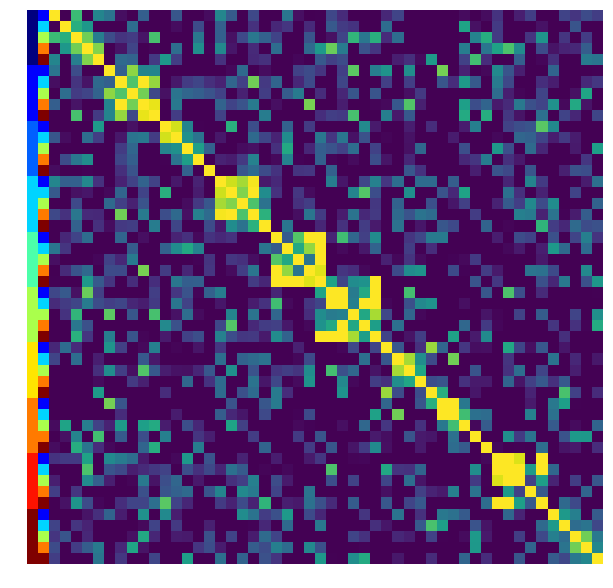

In [8]:
fig_width = 8
fig_height = fig_width * 50/52

seskey = np.array([1,2,3,4,5]*10, ndmin=2)
subkey = np.array([i for i in range(1,11) for k in range(5)], ndmin=2)
keys = np.hstack([subkey.T, 2*seskey.T])
f, (p0, p1) = plt.subplots(1,2, 
                           figsize=(fig_width, fig_height),
                           gridspec_kw = {'width_ratios':[2, 50], 'height_ratios':[50]})
p0.imshow(keys, cmap='jet')
p1.imshow(groupcorr,
          vmin=0.01,
          vmax=0.08)
p0.axis('off')
p1.axis('off')
plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
plt.show()

/home/vagrant/miniconda3/envs/py3/lib/python3.6/site-packages/pandas/core/frame.py:3790: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
/home/vagrant/miniconda3/envs/py3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


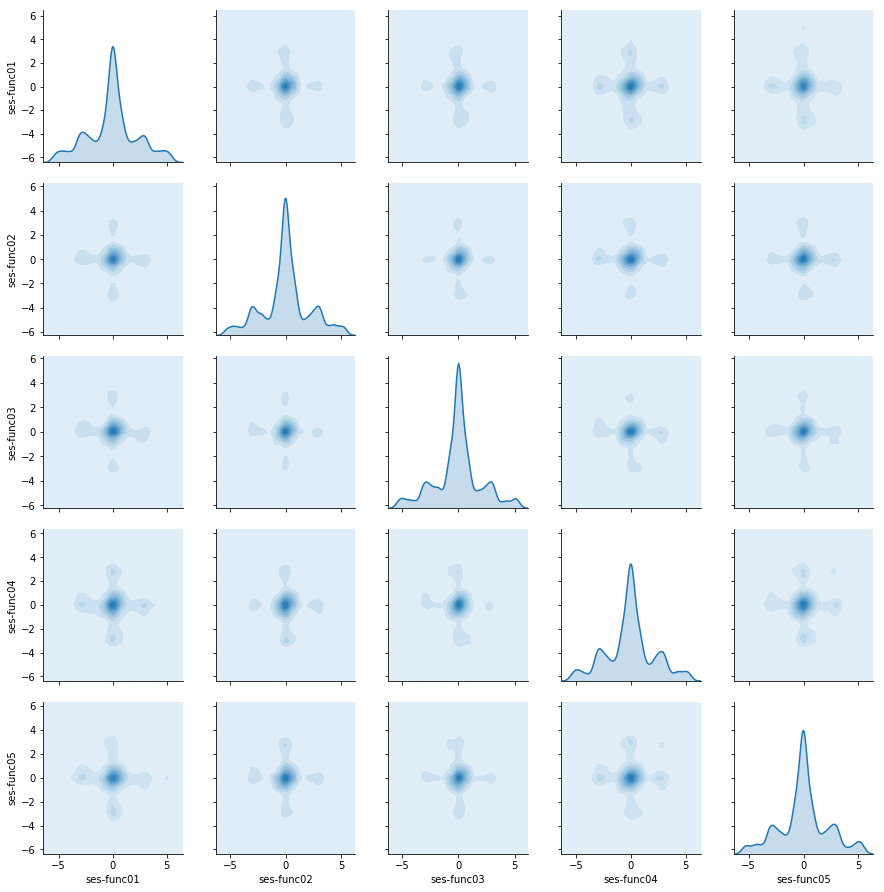

In [9]:
lags.fillna(0, inplace=True)
g = sns.PairGrid(lags['sub-MSC05'])
g.map_diag(sns.kdeplot, shade=True, legend=False)
g.map_offdiag(sns.kdeplot, shade=True, legend=False)